#### hello maize
- Maizeを実際に使ってみましょう
- 以下のコードはExampleというノードを2つワークフローに追加し最後にそれをConcatするという例です。
- オリジナルのノードはNodeクラスを継承することで作成できます。
- ワークフローはpythonでプログラム的に定義することもできるし（最も柔軟なアプローチ）、ツリーベースのシリアライゼーションフォーマット（JSON、YAML、TOML）で記述することもできます。
- その後、python内で実行したり、コマンドラインツールとして公開して他のパイプラインに統合したりすることができます。
- airflow*や*luigi*のようなパイプラインツールとは対照的に、maizeはサイクルや条件分岐を含む任意のトポロジーでワークフローを実行できます。

In [1]:
from maize.core.interface import Parameter, Output, MultiInput
from maize.core.node import Node
from maize.core.workflow import Workflow

In [2]:
class Example(Node):
    data: Parameter[str] = Parameter(default="Hello")
    out: Output[str] = Output()

    def run(self) -> Node:
        self.out.send(self.data.value)

class ConcatAndPrint(Node):
    inp: MultiInput[str] = MultiInput()

    def run(self):
        result = " ".join(inp.receive() for inp in self.inp)
        self.logger.info("Received: '%s'", result)



In [3]:
flow = Workflow(name='hello')
ex1 = flow.add(Example, name='ex1', parameters=dict(data='nice to meet you!'))
ex2 = flow.add(Example, name='ex2', parameters=dict(data='maize'))
concat = flow.add(ConcatAndPrint)
flow.connect(ex1.out, concat.inp)
flow.connect(ex2.out, concat.inp)
flow.check()

#### check and execute
- チェックで問題がない場合は実行プロセスを可視化してその後実行してみましょう。
- 実行プロセスはグラフで表現されます。Pipeline pilotやKnimeを利用されている方にとっては馴染みのある表現かと思います。

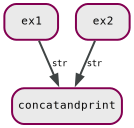

In [4]:
flow.visualize()

In [5]:
flow.execute()

2024-10-03 20:57:53,794 |     INFO |            hello | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-03 20:57:53,795 |     INFO |            hello | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-03 20:5

### step1
- ワークフローの最初の一歩はworkflow objectを作ることです。
- levelはロギングの冗長性を指定し（pythonのloggingモジュールを参照）、 cleanup_tempは実行中に作成されたディレクトリをクリーンアップすべきかどうかを指定し、 default_channel_sizeは一度にノード間チャネルに置くことができるアイテムの数を決定し、 logfileはSTDOUTではなくファイルにログを書き込むことを許可します。
```python
from pathlib import Path
flow = Workflow(
   name="Example",
   level="debug",
   cleanup_temp=False,
   default_channel_size=5,
   logfile=Path("out.log")
)
```

- 作成したWorkflowにはNodeを適宜追加できます。
```python
node = flow.add(Example)
node2 = flow.add(Example, name="other_example")
```
- また様々なオプションを渡すことも可能です。
```python
other = flow.add(
   OtherExample,
   name="other",
   parameters=dict(value=42),
   loop=True,
   fail_ok=True,
   n_attempts=3,
   max_loops=5
)
```

#### step2
- ノードを追加したあとは各ノードをつなげましょう。
```python
flow.connect(node.output, other.input)
```

#### step3
- 全部準備ができたら実行します。
```python
flow.execute()
```

# Nodeを作ってみる-1
- カスタムノードを作る場合はNodeを継承して作成します。
- 以下の例では、入力としてStringを受取り、出力として受け取ったデータの値を返すという挙動を取ります。

In [6]:
class Example(Node):
    out: Output[str] = Output()
    data: Parameter[str] = Parameter(default="hello")

    def run(self) -> None:
        self.out.send(self.data.value)

- OpenEye(Cadence)のROCSを実行するノードを見てみましょう。(testコードは省いています)
- このノードではIsomercollectionを入力として受取り、Isomercollectionを返します。Isomercollectionはモルオブジェクトと考えて良いと思います。実行にはOpeneyeのライセンスが必要ですので、本チュートリアルでは利用できない方もいらっしゃるかと思います。
```python
class ROCS(Node):
    """
    Performs ROCS shape-match scoring.

    See [#grant1996]_.

    Notes
    -----
    Requires a maize environment with ``openeye-toolkit`` installed. OpenEye in turn
    requires the OE_LICENSE environment variable to be set to a valid license file.

    References
    ----------
    .. [#grant1996] Grant, J. A., Gallardo, M. A. & Pickup, B. T. A fast method of
       molecular shape comparison: A simple application of a Gaussian description of
       molecular shape. Journal of Computational Chemistry 17, 1653-1666 (1996).

    See also the `full list of related publications
    <https://docs.eyesopen.com/applications/rocs/pub.html>`_.

    """

    SCORE_TAG = "ROCS"

    required_packages = ["openeye"]

    inp: Input[list[IsomerCollection]] = Input()
    """List of molecules to be scored"""

    out: Output[list[IsomerCollection]] = Output()
    """List of molecules with conformers best matching the query"""

    query: FileParameter[Annotated[Path, Suffix("sq")]] = FileParameter()
    """Reference query molecule"""

    max_stereo: Parameter[int] = Parameter(default=10)
    """Maximum number of stereocenters to be enumerated in molecule"""

    max_confs: Parameter[int] = Parameter(default=200)
    """Maximum number of conformers generated per stereoisomer"""

    energy_window: Parameter[int] = Parameter(default=10)
    """Difference between lowest and highest energy conformer"""

    similarity_measure: Parameter[_SimMeasureType] = Parameter(default="Tanimoto")
    """Similarity between reference and molecule"""

    color_weight: Parameter[float] = Parameter(default=0.5)
    """Weight applied to the color-matching score"""

    shape_weight: Parameter[float] = Parameter(default=0.5)
    """Weight applied to the shape-matching score"""

    strict: Flag = Flag(default=False)
    """If ``True`` will fail and raise an exception when failing to score a molecule"""

    gpu: Flag = Flag(default=True)
    """Whether to use the GPU"""

    def run(self) -> None:
        from openeye import oechem, oeomega, oequacpac, oeshape

        # Conformer generation options
        omega_options = oeomega.OEOmegaOptions()
        omega_options.SetStrictStereo(False)
        omega_options.SetEnergyWindow(self.energy_window.value)
        omega_options.SetMaxConfs(self.max_confs.value)
        omega_options.GetTorDriveOptions().SetUseGPU(self.gpu.value)
        omega = oeomega.OEOmega(omega_options)

        overlay = _prepare_overlay(self.query.filepath)
        prep = oeshape.OEOverlapPrep()

        # Normalize weights in case they don't add up to 1.0
        shape_weight = self.shape_weight.value
        color_weight = self.color_weight.value
        weight_sum = shape_weight + color_weight
        shape_weight, color_weight = shape_weight / weight_sum, color_weight / weight_sum

        mols = self.inp.receive()
        for mol in mols:
            if len(mol.molecules) > 1:
                self.logger.warning(
                    "Molecule '%s' has more than one isomer. ROCS performs it's own "
                    "conformer generation and will ignore all but the first isomer.",
                    mol.smiles,
                )

            isomer = mol.molecules[0]
            oemol = isomer2oe(isomer)
            oequacpac.OEGetReasonableProtomer(oemol)

            # Create conformers
            _gen_conf(oemol, omega=omega, max_stereo=self.max_stereo.value)

            # Non-zero returncode indicates an error
            if omega.Build(oemol):
                if self.strict.value:
                    raise ChemistryException(f"Omega failed to build '{isomer.name or isomer.inchi}'")
                self.logger.warning("Omega failed to build '%s'", isomer.name or isomer.inchi)
                isomer.add_score(self.SCORE_TAG, np.nan)
                continue

            prep.Prep(oemol)
            scorer, result = _score(
                oemol,
                similarity_measure=self.similarity_measure.value,
                overlay=overlay,
                shape_weight=shape_weight,
                color_weight=color_weight,
            )
            self.logger.info("Shape matched '%s' with a score of %s", isomer.name or isomer.inchi, result)
            isomer.set_tag("origin", self.name)
            isomer.add_score(self.SCORE_TAG, result)
            mol.primary_score_tag = self.SCORE_TAG
            docked = oechem.OEGraphMol(oemol.GetConf(oechem.OEHasConfIdx(scorer.GetFitConfIdx())))
            oe2isomer_conf(docked, isomer)

        self.out.send(mols)



# Nodeを作ってみる-2
- カスタムノードではファイルの受け渡しもできます。
- 中間ファイルを出力しそれを次に渡すと行った処理を考える際に便利です。
- パラメータの型としてpathlib.Pathを指定しましょう。
- これはMaize-contribのSmilesのファイルを読むクラスのコードです。

```python
from typing import Annotated, Any, Callable, Iterable, List, Literal, TypeVar
from maize.core.node import Node
from maize.core.interface import Input, Output, Parameter, FileParameter, Suffix, Flag, MultiInput

class LoadSmiles(Node):
    """Load SMILES codes from a ``.smi`` file."""

    path: FileParameter[Annotated[Path, Suffix("smi")]] = FileParameter()
    """SMILES file input"""

    out: Output[list[str]] = Output()
    """SMILES output"""

    sample: Parameter[int] = Parameter(optional=True)
    """Take a sample of SMILES"""

    def run(self) -> None:
        with self.path.filepath.open() as file:
            smiles = [smi.strip("\n") for smi in file.readlines()]
            if self.sample.is_set:
                smiles = random.choices(smiles, k=self.sample.value)
            self.out.send(smiles)
```

- 上の例ではSmilesファイルを読むことに特化していましが、同じ要領でテキストファイルを読み込みそれをプリントするWFを書いてみましょう。
- データは../dataにあるのをデフォルトで利用していますが適宜変えてもらって構いません。

In [7]:
from typing import Annotated, Any, Callable, Iterable, List, Literal, TypeVar
from maize.core.node import Node
from maize.core.interface import Input, Output, Parameter, FileParameter, Suffix, Flag, MultiInput
from pathlib import Path

class LoadText(Node):
    path: FileParameter[Path] = FileParameter()
    out: Output[str] = Output()
    def run(self) -> None:
        with self.path.filepath.open() as file:
            text_data = "\n\n"+"".join([line for line in file.readlines()])+"\n\n"
            self.out.send(text_data)

class PrintTxt(Node):
    inp: Input[str] = Input()

    def run(self):
        result = self.inp.receive()
        self.logger.info("Received: '%s'", result)

In [8]:
flow = Workflow(
   name="file_handling",
   #level="debug",
   cleanup_temp=False,
   #logfile=Path("out.log")
)

In [9]:
filepath = Path("../data/loadfile_demo.txt")
load = flow.add(LoadText, parameters=dict(path=filepath))
printer = flow.add(PrintTxt)

In [10]:
flow.connect(load.out, printer.inp)

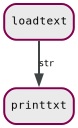

In [11]:
flow.check()
flow.visualize()

In [12]:
flow.execute()

2024-10-03 21:03:42,370 |     INFO |    file_handling | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-03 21:03:42,373 |     INFO |    file_handling | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-03 21:0

# 条件により分岐するワークフロー


In [13]:
from maize.core.node import Node
from maize.core.interface import Input, Output
from maize.core.workflow import Workflow
from maize.steps.io import LoadData, LogResult
from maize.steps.plumbing import Merge

class Condition(Node):
    inp: Input[int] = Input()
    out_a: Output[int] = Output()
    out_b: Output[int] = Output()

    def run(self) -> None:
        data = self.inp.receive()
        if data < 10:
            self.out_a.send(data)
        else:
            self.out_b.send(data)

In [14]:
flow = Workflow(name="cycle")
load = flow.add(LoadData[int], parameters={"data": 17})
cond = flow.add(Condition)
out_a = flow.add(LogResult, name="out_a")
out_b = flow.add(LogResult, name="out_b")
flow.connect_all(
    (load.out, cond.inp),
    (cond.out_a, out_a.inp),
    (cond.out_b, out_b.inp)
)

In [15]:
flow.check()

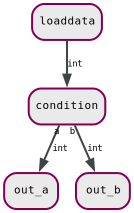

In [16]:
flow.visualize()

In [17]:
flow.execute()

2024-10-03 21:04:09,364 |     INFO |            cycle | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-03 21:04:09,366 |     INFO |            cycle | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-03 21:0

# 繰り返しを含むワークフロー
- Dealyは指定された秒数time.sleepによって処理を止めます
- Mergeは

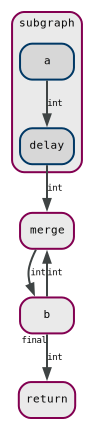

In [18]:
from maize.core.graph import Graph
from maize.core.interface import Parameter, Input, Output
from maize.core.node import Node
from maize.core.workflow import Workflow

from maize.steps.plumbing import Delay, Merge
from maize.steps.io import Return
from typing import TypeVar, Generic
T = TypeVar("T")

class A(Node):
    out: Output[int] = Output()
    send_val: Parameter[int] = Parameter()

    def run(self) -> None:
        self.out.send(self.send_val.value)


class B(Node):
    inp: Input[int] = Input()
    out: Output[int] = Output()
    final: Output[int] = Output()

    def run(self) -> None:
        val = self.inp.receive()
        if val > 48:
            self.logger.debug("%s stopping", self.name)
            self.final.send(val)
            return
        print(val+2)
        self.out.send(val + 2)

class SubGraph(Graph):
    
    def build(self) -> None:
        a = self.add(A, parameters=dict(send_val=36))
        d = self.add(Delay[int], parameters=dict(delay=1))
        self.connect(a.out, d.inp)
        #map_portを使いサブグラフの出力ポートを作成　普通のノードはself.out.send(xxx) etc
        self.out = self.map_port(d.out)
        self.val = self.combine_parameters(a.send_val, name="val")


flow = Workflow(name="test")
sg = flow.add(SubGraph)
b = flow.add(B, loop=True)
merge = flow.add(Merge[int])
ret = flow.add(Return[int])
flow.connect(sg.out, merge.inp)
flow.connect(merge.out, b.inp)
flow.connect(b.out, merge.inp)
flow.connect(b.final, ret.inp)
flow.combine_parameters(sg.val, name="val")
flow.check()
flow.visualize()

In [19]:
flow.execute()

2024-10-03 21:04:12,618 |     INFO |             test | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-03 21:04:12,621 |     INFO |             test | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-03 21:0

38
40


2024-10-03 21:04:17,156 |     INFO |             test | Workflow status
                                   |                a | COMPLETED
                                   |                b | RUNNING (0 | 1)
                                   |            delay | STOPPED
                                   |            merge | RUNNING
                                   |           return | WAITING_FOR_INPUT


42
44


2024-10-03 21:04:19,653 |     INFO |             test | Workflow status
                                   |                a | COMPLETED
                                   |                b | RUNNING (0 | 1)
                                   |            delay | STOPPED
                                   |            merge | WAITING_FOR_INPUT
                                   |           return | WAITING_FOR_INPUT


46
48


2024-10-03 21:04:21,659 |     INFO |             test | Workflow status
                                   |                a | COMPLETED
                                   |                b | RUNNING (0 | 1)
                                   |            delay | STOPPED
                                   |            merge | RUNNING
                                   |           return | WAITING_FOR_INPUT


50


2024-10-03 21:04:22,702 |     INFO |             test | Node 'return' finished (3/5)
2024-10-03 21:04:23,201 |     INFO |             test | Node 'b' finished (4/5)
2024-10-03 21:04:23,666 |     INFO |             test | Node 'merge' finished (5/5)
2024-10-03 21:04:24,170 |     INFO |             test | Execution completed :) total runtime: 0:00:10.968094
	2 nodes completed successfully
	3 nodes stopped due to closing ports
	0 nodes failed
	0:00:31.511898 total walltime
	0:00:19.937257 spent waiting for resources or other nodes
